# Laboratorium 3 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

In [22]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud

In [3]:
PATH = 'socialmediadata-beeradvocate/data/beer_reviews.csv'
POSITIVE_SCORE_THRESHOLD = 4 # recenzje z co najmniej taka ocena wezmiemy pod uwage
NEGATIVE_SCORE_THRESHOLD = 2 # recenzje ponizej tego progu wezmiemy jako przyklady negatywne
ACTIVITY_THRESHOLD = 5 # minimalna liczba pozytywnych lub negatywnych recenzji per uzytkownik
MIN_SCORES_COUNT = 5 # minimalna liczba ocen pojedynczego elementu
VECTOR_SIZE = 20 # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10 # na ile segmentow chcemy podzielic populacje uzytkownikow

In [9]:
# wczytujemy dane

def parse_headers(column_names):
    beer_id_column =  column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column =  column_names.index('review_profilename')
    score_column =  column_names.index('review_overall')
    return beer_id_column, beer_style_column, user_id_column, score_column


def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return line[beer_id_column], line[beer_style_column], line[user_id_column], float(line[score_column])

def read_and_parse_reviews(path, positive_score_threshold, negative_score_threshold):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
    
        users_favourite_beers = defaultdict(list)
        users_hated_beers = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            if score >= positive_score_threshold:
                users_favourite_beers[user_id].append(beer_id)
            elif score <= negative_score_threshold:
                users_hated_beers[user_id].append(beer_id)

    return users_favourite_beers, users_hated_beers

def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
        beer_styles = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            beer_styles[beer_id] = beer_style
        return beer_styles

# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers, users_hated_beers = read_and_parse_reviews(PATH, POSITIVE_SCORE_THRESHOLD, NEGATIVE_SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

In [14]:
list(beer_styles.items())[:5]

[('47986', 'Hefeweizen'),
 ('48213', 'English Strong Ale'),
 ('48215', 'Foreign / Export Stout'),
 ('47969', 'German Pilsener'),
 ('64883', 'American Double / Imperial IPA')]

## Część 2. - osadzenia użytkowników

In [16]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model = Word2Vec(sentences=users_favourite_beers.values(), vector_size=VECTOR_SIZE, window=5, min_count=MIN_SCORES_COUNT, workers=4)

In [31]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow

def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    # inicjalizujemy wektor zerami
    v = np.zeros(vector_size)
    
    # iterujemy po liscie user_favourite_beers, odczytujemy z modelu wektor reprezentujacy kazde piwo i dodajemy do wektora
    #   uzyj: model.wv[beer_id]
    
    n = 0

    for beer_id in user_favourite_beers:
        if beer_id in model.wv:
            v += model.wv[beer_id]
            n += 1
    #

    return v / n if n > 0 else v
# end procedure

def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    mean_users_vectors = {}
    
    for user_id, user_favourite_beers in users_favourite_beers.items():
        mean_users_vectors[user_id] = get_mean_vector_for_user(user_favourite_beers, model, vector_size)
    #

    return mean_users_vectors
# end procedure

user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

## Część 3. - klasteryzacja

In [23]:
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, porownaj co najmniej 2 rozne

def get_users_segmentation(user_vectors, vector_size, segments_count, clustering_algorithm):
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = list(user_vectors.keys())
    vectors = list(user_vectors.values())
    
    # zamieniamy liste wektorow w macierz
    users_array = np.stack(vectors, axis=0)

    # zaimplementuj wsparcie dla co najmniej dwoch algorytmow
    if clustering_algorithm == 'kmeans':

        clustering = KMeans(
            n_clusters=segments_count
        ).fit_predict(users_array)

    elif clustering_algorithm == 'agglomerative':
        
        clustering = AgglomerativeClustering(
            n_clusters=segments_count
        ).fit_predict(users_array)
    #

    segmentation = {}
    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster
    
    for user_id, cluster in zip(users, clustering):
        segmentation[user_id] = cluster
    #

    return segmentation
# end procedure

segmentation1 = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'kmeans')
segmentation2 = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')

In [24]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation):
    return Counter(segmentation.values())

print(get_segment_sizes(segmentation1))
print(get_segment_sizes(segmentation2))

Counter({np.int32(1): 17523, np.int32(7): 2425, np.int32(6): 1679, np.int32(0): 1628, np.int32(8): 1506, np.int32(3): 1442, np.int32(2): 1418, np.int32(9): 1275, np.int32(4): 1112, np.int32(5): 278})
Counter({np.int64(3): 12814, np.int64(4): 4346, np.int64(9): 4264, np.int64(1): 2219, np.int64(0): 1431, np.int64(2): 1364, np.int64(8): 1107, np.int64(5): 1026, np.int64(7): 991, np.int64(6): 724})


In [25]:
# obliczamy metryke jakosci segmentacji
# metryka przyjmuje wartosci z przedzialu [-1, 1] - im wiecej, tym lepiej
users, user_vectors_list = zip(*user_vectors.items())
segments_list1 = [segmentation1[u] for u in users]
segments_list2 = [segmentation2[u] for u in users]

mean_silhouette1 = silhouette_score(user_vectors_list, segments_list1, metric='euclidean')
per_sample_silhouettes1 = silhouette_samples(user_vectors_list, segments_list1, metric='euclidean')

mean_silhouette2 = silhouette_score(user_vectors_list, segments_list2, metric='euclidean')
per_sample_silhouettes2 = silhouette_samples(user_vectors_list, segments_list2, metric='euclidean')

In [26]:
# rysujemy wykres
def plot_histogram(values, mean_value):
    plt.hist(values, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_value, linestyle='dashed', linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height*1.05, 'Mean: {:.3f}'.format(mean_value))
    plt.show()

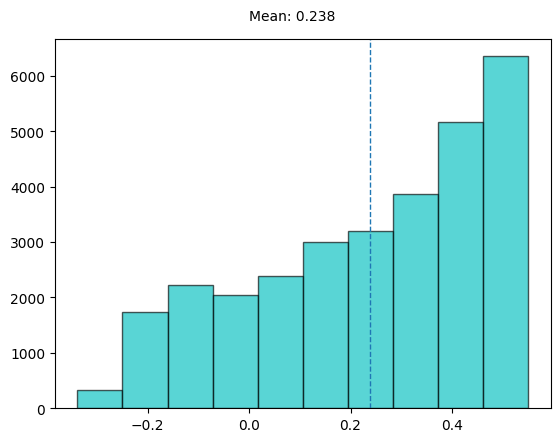

In [27]:
plot_histogram(per_sample_silhouettes1, mean_silhouette1)

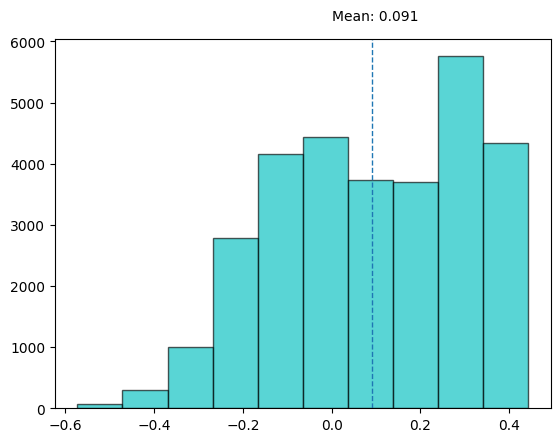

In [28]:
plot_histogram(per_sample_silhouettes2, mean_silhouette2)

## Część 3.5. - negative sampling

Wykonaj kroki obliczania embeddingów uytkowników, klasteryzacji z użyciem najlepszego według Ciebie algorytmu i obliczania sylwetki - ale tym razem embeddingi to średnia ważona, gdzie elementy `users_favourite_beers[user_id]` mają wagę `1`, a elementy `users_hated_beers[user_id]` mają wagę `-1`.

Możesz także odsiać tych użytkowników, o których wiemy zbyt mało (czyli którzy mają łącznie mniej niż `ACTIVITY_THRESHOLD` elementów w listach `users_favourite_beers[user_id]` i `users_hated_beers[user_id]`).

Pamiętaj, by wykorzystać ten sam wytrenowany już wcześniej model Item2Vec, który oblicza mebeddingi poszczególnych elementów.

In [ ]:
def get_weighted_mean_vector_for_user(user_favourite_beers, user_hated_beers, model, vector_size):
    # inicjalizujemy wektor zerami
    v = np.zeros(vector_size)
    
    # iterujemy po liscie user_favourite_beers, odczytujemy z modelu wektor reprezentujacy kazde piwo i dodajemy do wektora
    #   uzyj: model.wv[beer_id]
    
    if len(user_favourite_beers) + len(user_hated_beers) < ACTIVITY_THRESHOLD:
        return None
    #

    n = 0
    
    for beer_id in user_favourite_beers:
        if beer_id in model.wv:
            v += model.wv[beer_id]
            n += 1
    #
    for beer_id in user_hated_beers:
        if beer_id in model.wv:
            v -= model.wv[beer_id]
            n -= 1
    #

    return v / n if n > 0 else v
# end procedure

def get_weighted_mean_user_vectors(users_favourite_beers, users_hated_beers, model, vector_size):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    mean_users_vectors = {}
    
    for user_id, user_favourite_beers in users_favourite_beers.items():
        result = get_mean_vector_for_user(user_favourite_beers, model, vector_size)
        
        if result is None: continue 
        mean_users_vectors[user_id] = result
    #

    return mean_users_vectors
# end procedure

user_vectors2 = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

In [32]:
segmentation3 = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'kmeans')
segmentation4 = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')

In [34]:
users2, user_vectors_list2 = zip(*user_vectors2.items())
segments_list3 = [segmentation3[u] for u in users]
segments_list4 = [segmentation4[u] for u in users]

mean_silhouette3 = silhouette_score(user_vectors_list2, segments_list3, metric='euclidean')
per_sample_silhouettes3 = silhouette_samples(user_vectors_list2, segments_list3, metric='euclidean')

mean_silhouette4 = silhouette_score(user_vectors_list2, segments_list4, metric='euclidean')
per_sample_silhouettes4 = silhouette_samples(user_vectors_list2, segments_list4, metric='euclidean')

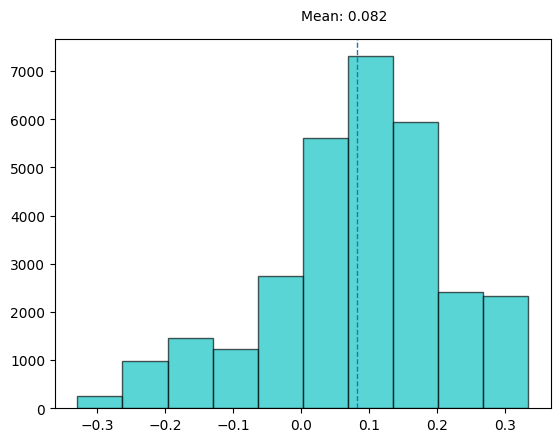

In [36]:
plot_histogram(per_sample_silhouettes3, mean_silhouette3)

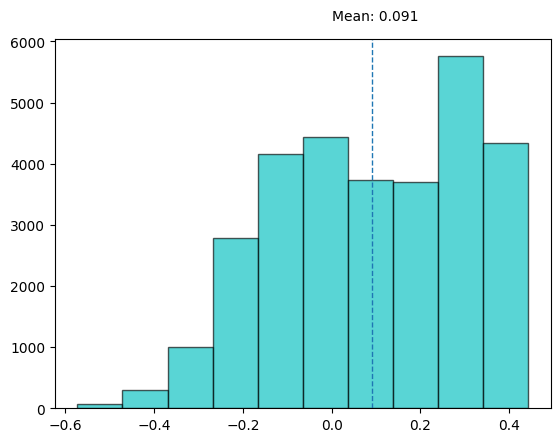

In [38]:
plot_histogram(per_sample_silhouettes4, mean_silhouette4)

## Część 4. - opisy segmentów

In [41]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal

def get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, segments_count):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]
    
    for user_id, beers in users_favourite_beers.items():
        segment_id = segmentation[user_id]
        for beer_id in beers:
            beer_style = beer_styles[beer_id]
            beer_styles_per_segment[segment_id][beer_style] += 1
    #
    
    return beer_styles_per_segment
#

def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)
    
    for beer_styles in beer_styles_per_segment.values():
        for beer_style, popularity in beer_styles.items():
            total_popularity[beer_style] += popularity
    #

    return total_popularity
#

per_segment_styles_popularity = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation1, SEGMENTS_COUNT)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

In [42]:
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}

def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    return {segment_id: dict(Counter(beer_styles).most_common(N)) for segment_id, beer_styles in per_segment_styles_popularity.items()}
#

def most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, N):
    result = {}

    for segment_id, beer_styles_popularity in per_segment_styles_popularity.items():
        distinctive_scores = {
            beer_style: count / total_styles_popularity[beer_style]
            for beer_style, count in beer_styles_popularity.items()
        }

        top_styles = dict(Counter(distinctive_scores).most_common(N))
        result[segment_id] = top_styles

    return result
#
  
top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, top_N)

## Część 5. - wizualizacja

In [43]:
# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    wordcloud1 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

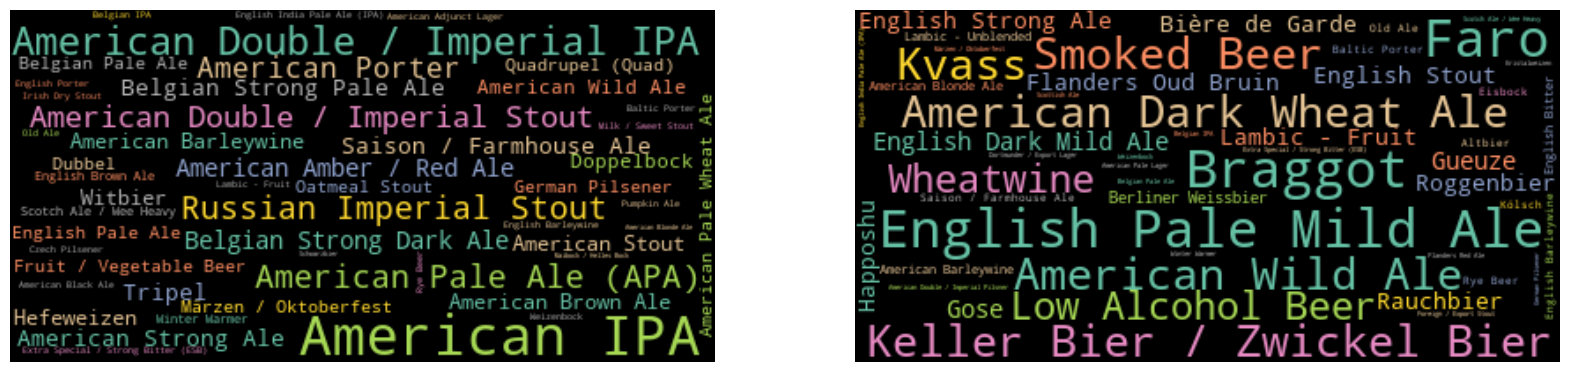

In [44]:
visualise_styles(most_popular, most_distinctive, 1)

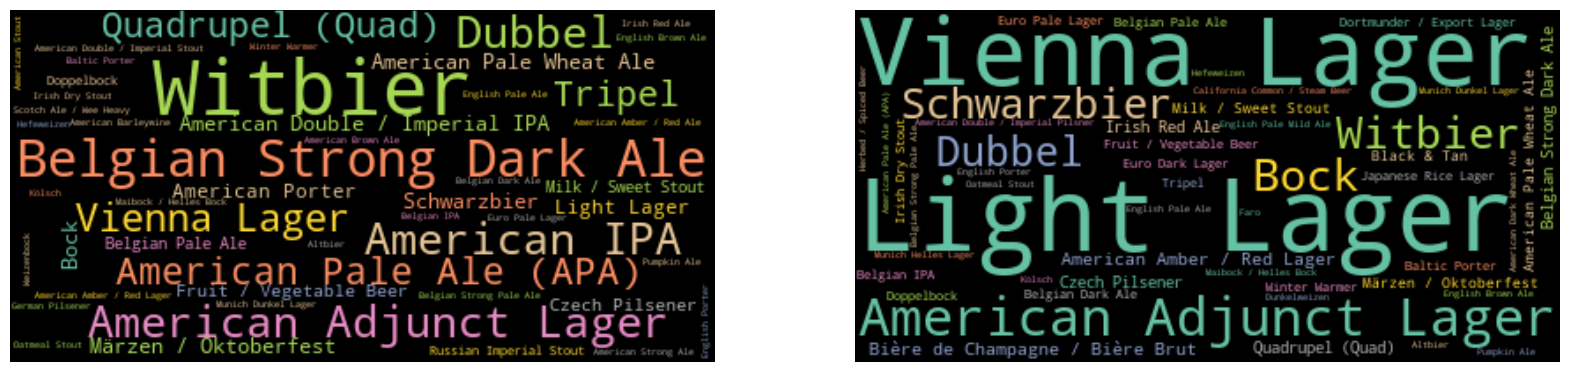

In [45]:
visualise_styles(most_popular, most_distinctive, 3)